# Avaliando o impacto de uma política pública: **Controle Sintético** 

Nos dados do HISP, possuíamos uma série de amostras que compunham nossos dados de controle e tratamento.

Contudo, com amostras pequenas ou dados mais agregados (ao nível nacional ou estatal, por exemplo), não podemos ter certeza de estarmos usando um grupo de controle adequado.
No entanto, sempre podemos **criar nossas unidades de comparação** a partir de uma combinação de várias unidades não-tratadas, ou seja, fazendo um grupo de **controle sintético**.

----

## Leitura dos Dados

In [1]:
## Já instalando bibliotecas necessárias
from IPython.display import clear_output # limpa o output de uma célula
!pip install linearmodels
!pip install SyntheticControlMethods
!pip install 'scipy==1.4.1' --force-reinstall  # necessário para rodar o SyntethicControlMethods

clear_output()  # limpando o texto

In [2]:
## Importando o que for necessário
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from linearmodels.iv import IV2SLS
from statsmodels.formula.api import ols, probit, logit
from patsy import dmatrices
from SyntheticControlMethods import Synth  # controle sintético

In [3]:
## Montando o Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
## Lendo os dados
sCaminho = "/content/drive/Othercomputers/Meu modelo MacBook Air/Documents/IPEA/Curso IDP/Avaliação de Impacto de Políticas - World Bank/Dados/"
# sCaminho = '/content/drive/MyDrive/Projetos/IDP/MBA/SetorPublicoI/PNADC/'

sArquivo = "base cigarros.dta"

## Lendo o DataFrame
df = pd.read_stata(f"{sCaminho}{sArquivo}")

# Vendo o tamanho da base
print(f"Linhas: {df.shape[0]}; Colunas: {df.shape[1]}")

Linhas: 1209; Colunas: 7


In [5]:
## Vendo a descrição das variáveis (só funciona com arquivos .dta)
# Lendo novamente a base, mas agora com iterator, o que retorna um objeto do tipo StataReader
stata_reader = pd.read_stata(f"{sCaminho}{sArquivo}", iterator=True)

# Pegando as descrições das variáveis
descricoes = stata_reader.variable_labels()
descricoes

{'age15to24': 'percent of state population aged 15-24 years',
 'beer': 'beer consumption per capita',
 'cigsale': 'cigarette sale per capita (in packs)',
 'lnincome': 'log state per capita gdp',
 'retprice': 'retail price of cigarettes',
 'state': 'state no',
 'year': 'year'}

In [6]:
## Vendo as primeiras linha do df
df.head(10)

,state,year,cigsale,lnincome,beer,age15to24,retprice
0,Rhode Island,1970.0,123.900002,NaN,NaN,0.183158,39.299999
1,Tennessee,1970.0,99.800003,NaN,NaN,0.178044,39.900002
2,Indiana,1970.0,134.600006,NaN,NaN,0.176516,30.600000
3,Nevada,1970.0,189.500000,NaN,NaN,0.161554,38.900002
4,Louisiana,1970.0,115.900002,NaN,NaN,0.185185,34.299999
5,Oklahoma,1970.0,108.400002,NaN,NaN,0.175459,38.400002
6,New Hampshire,1970.0,265.700012,NaN,NaN,0.170732,31.400000
7,North Dakota,1970.0,93.800003,NaN,NaN,0.184466,37.299999
8,Arkansas,1970.0,100.300003,NaN,NaN,0.169007,36.700001
9,Virginia,1970.0,124.300003,NaN,NaN,0.189422,28.799999


In [7]:
## Descrevendo o DataFrame
df.describe()

,year,cigsale,lnincome,beer,age15to24,retprice
count,1209.000000,1209.000000,1014.000000,546.000000,819.000000,1209.000000
mean,1985.000000,118.893219,9.861625,23.430393,0.175472,108.341919
std,8.947973,32.767406,0.170677,4.223190,0.015159,64.381996
min,1970.000000,40.700001,9.397449,2.500000,0.129448,27.299999
25%,1977.000000,100.900002,9.739134,20.900000,0.165816,50.000000
50%,1985.000000,116.300003,9.860844,23.299999,0.178121,95.500000
75%,1993.000000,130.500000,9.972764,25.100000,0.186660,158.399994
max,2000.000000,296.200012,10.486617,40.400002,0.203675,351.200012


In [8]:
## Vendo quantidade de Estados e anos
print(f"Estados: {df['state'].nunique()}.")
print(f"Anos: {df['year'].nunique()}.")

Estados: 39.
Anos: 31.


## Controle Sintético - Proposição 99 e a Venda de Cigarros

Em 1988, a California passou a lei chamada de "Proposição 99", que taxava o maço de cigarros em 25%, além de proibir a venda em *vending machines* em áreas públicas acessadas pela população mais jovem, além do banimento da venda de uma unidade de cigarro.

Para analisar o impacto da política, temos dados de 39 estados - sendo um deles a California - ao longo de 31 anos (1970 a 2000). É importante dizer que nenhum dos outros 38 territórios - os "doadores" para o controle sintético - passou por alguma política similar.

A variável de interesse é `cigsale` - a venda de maços de cigarros per capita, afetada, inicialmente, por `state` e `retprice` - o preço do cigarro no varejo.

### Análise Descritiva

In [9]:
## Vamos primeiro criar duas dummies: uma que indica se o estado é a california
## e outra que mostra se aquela observação é pré ou pós intervenção (1988)
df['california'] = np.where(df['state'] == "California", 1, 0)
df['pos_tratamento'] = np.where(df['year'] > 1988, 1, 0)

# Vendo resultado
df.query('california == 1').head(20)

,state,year,cigsale,lnincome,beer,age15to24,retprice,california,pos_tratamento
17,California,1970.0,123.000000,NaN,NaN,0.178158,38.799999,1,0
68,California,1971.0,121.000000,NaN,NaN,0.179296,39.700001,1,0
96,California,1972.0,123.500000,9.930814,NaN,0.180434,39.900002,1,0
150,California,1973.0,124.400002,9.955092,NaN,0.181572,39.900002,1,0
164,California,1974.0,126.699997,9.947999,NaN,0.182710,41.900002,1,0
209,California,1975.0,127.099998,9.937167,NaN,0.183848,45.000000,1,0
240,California,1976.0,128.000000,9.976858,NaN,0.184987,48.299999,1,0
288,California,1977.0,126.400002,10.002700,NaN,0.186125,49.000000,1,0
315,California,1978.0,126.099998,10.045565,NaN,0.187263,58.700001,1,0
378,California,1979.0,121.900002,10.054688,NaN,0.188401,60.099998,1,0


In [10]:
## Vendo como se comportam as tendências na venda de cigarros na California e nos outros estados

# Agrupando por ano e California e pegando as médias anuais
dfAgrupCali = df.groupby(['year', 'california'])['cigsale'].mean().unstack()
dfAgrupCali.head(5)

california,0,1
year,,
1970.0,120.084213,123.000000
1971.0,123.863159,121.000000
1972.0,129.178955,123.500000
1973.0,131.539474,124.400002
1974.0,134.668427,126.699997


In [11]:
## Mudando as colunas
dfAgrupCali.columns = ["Outros Estados", "California"]
dfAgrupCali.head(5)

,Outros Estados,California
year,,
1970.0,120.084213,123.000000
1971.0,123.863159,121.000000
1972.0,129.178955,123.500000
1973.0,131.539474,124.400002
1974.0,134.668427,126.699997


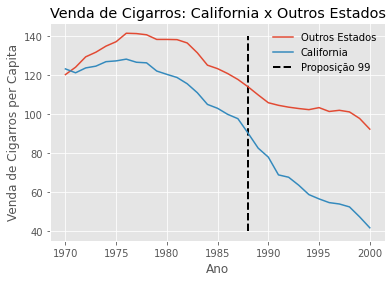

In [12]:
# Estilo dos gráficos
from matplotlib import style
style.use("ggplot")

# Objeto gráfico
fig = plt.Figure(figsize=(10, 10), dpi=150)

# Plot
dfAgrupCali.plot()

# Linha vertical da proposição 99
plt.vlines(x=1988, ymin=40, ymax=140, linestyle="--", lw=2, label="Proposição 99")

# Títulos
plt.xlabel("Ano")
plt.ylabel("Venda de Cigarros per Capita")
plt.title("Venda de Cigarros: California x Outros Estados")

## Configurando legenda com fundo transparente
plt.legend(frameon=False, facecolor=None)

### Estimação do Controle Sintético

Em geral, vemos que californianos já compravam menos cigarros do que a média dos outros estados, mas esse *gap* parece ter aumentado a partir da Proposição 99. Será que a lei realmente teve um efeito?

In [13]:
## Arrumando o data set
# Pegando apenas as colunas relevantes (sem as dummies que criamos antes)
dfCS = df[['state', 'year', 'cigsale', 'lnincome', 'beer', 'age15to24', 'retprice']].copy()

# Ordenando
dfCS.sort_values(by=["state", "year"], inplace=True, ignore_index=True)

# Vendo o resultado
dfCS

,state,year,cigsale,lnincome,beer,age15to24,retprice
0,Alabama,1970.0,89.800003,NaN,NaN,0.178862,39.599998
1,Alabama,1971.0,95.400002,NaN,NaN,0.179928,42.700001
2,Alabama,1972.0,101.099998,9.498476,NaN,0.180994,42.299999
3,Alabama,1973.0,102.900002,9.550107,NaN,0.182060,42.099998
4,Alabama,1974.0,108.199997,9.537163,NaN,0.183126,43.099998
...,...,...,...,...,...,...,...
1204,Wyoming,1996.0,110.300003,10.016768,24.6,NaN,162.500000
1205,Wyoming,1997.0,108.800003,10.025613,24.6,NaN,164.100006
1206,Wyoming,1998.0,102.900002,NaN,NaN,NaN,168.800003
1207,Wyoming,1999.0,104.800003,NaN,NaN,NaN,189.600006


In [14]:
## Além disso, podemos adicionar as vendas de cigarro em diferentes anos como covariadas no modelo
dfVendas1975 = dfCS.query('year == 1975')[['state', 'cigsale']]
dfVendas1975.rename(columns={'cigsale':'cigsale75'}, inplace=True)
dfVendas1975.head(5)

,state,cigsale75
5,Alabama,111.699997
36,Arkansas,114.800003
67,California,127.099998
98,Colorado,131.000000
129,Connecticut,110.199997


In [15]:
## Usando um merge para adicionar ao DataFrame
dfCS = dfCS.merge(dfVendas1975, how='left', on='state')
dfCS

,state,year,cigsale,lnincome,beer,age15to24,retprice,cigsale75
0,Alabama,1970.0,89.800003,NaN,NaN,0.178862,39.599998,111.699997
1,Alabama,1971.0,95.400002,NaN,NaN,0.179928,42.700001,111.699997
2,Alabama,1972.0,101.099998,9.498476,NaN,0.180994,42.299999,111.699997
3,Alabama,1973.0,102.900002,9.550107,NaN,0.182060,42.099998,111.699997
4,Alabama,1974.0,108.199997,9.537163,NaN,0.183126,43.099998,111.699997
...,...,...,...,...,...,...,...,...
1204,Wyoming,1996.0,110.300003,10.016768,24.6,NaN,162.500000,160.699997
1205,Wyoming,1997.0,108.800003,10.025613,24.6,NaN,164.100006,160.699997
1206,Wyoming,1998.0,102.900002,NaN,NaN,NaN,168.800003,160.699997
1207,Wyoming,1999.0,104.800003,NaN,NaN,NaN,189.600006,160.699997


In [16]:
## Fazendo a mesma coisa para 1980 e 1988
# 1980
dfVendas1980 = dfCS.query('year == 1980')[['state', 'cigsale']]
dfVendas1980.rename(columns={'cigsale':'cigsale80'}, inplace=True)
dfCS = dfCS.merge(dfVendas1980, how='left', on='state')

# 1988
dfVendas1988 = dfCS.query('year == 1988')[['state', 'cigsale']]
dfVendas1988.rename(columns={'cigsale':'cigsale88'}, inplace=True)
dfCS = dfCS.merge(dfVendas1988, how='left', on='state')

# Vendo resultado
dfCS

,state,year,cigsale,lnincome,beer,age15to24,retprice,cigsale75,cigsale80,cigsale88
0,Alabama,1970.0,89.800003,NaN,NaN,0.178862,39.599998,111.699997,123.199997,112.099998
1,Alabama,1971.0,95.400002,NaN,NaN,0.179928,42.700001,111.699997,123.199997,112.099998
2,Alabama,1972.0,101.099998,9.498476,NaN,0.180994,42.299999,111.699997,123.199997,112.099998
3,Alabama,1973.0,102.900002,9.550107,NaN,0.182060,42.099998,111.699997,123.199997,112.099998
4,Alabama,1974.0,108.199997,9.537163,NaN,0.183126,43.099998,111.699997,123.199997,112.099998
...,...,...,...,...,...,...,...,...,...,...
1204,Wyoming,1996.0,110.300003,10.016768,24.6,NaN,162.500000,160.699997,158.100006,114.300003
1205,Wyoming,1997.0,108.800003,10.025613,24.6,NaN,164.100006,160.699997,158.100006,114.300003
1206,Wyoming,1998.0,102.900002,NaN,NaN,NaN,168.800003,160.699997,158.100006,114.300003
1207,Wyoming,1999.0,104.800003,NaN,NaN,NaN,189.600006,160.699997,158.100006,114.300003


In [17]:
## Fittando o modelo de controle sintético
modControleSintetico = Synth(dataset=dfCS,
                             outcome_var="cigsale",
                             id_var="state",
                             time_var="year",
                             treatment_period=1989,  # 1a observação APÓS o tratamento
                             treated_unit="California",
                             n_optim=30,
                             pen="auto")  # corrige para vieses

In [18]:
## Vendo os pesos de cada estado
modControleSintetico.original_data.weight_df

,Weight
Nevada,0.300399
New Mexico,0.552538
Utah,0.147063


In [19]:
## Comparando os dados da california com o que foi gerado no controle sintético
# Queremos:
  # a) que as duas primeiras colunas sejam similares
  # b) que o WMAPE (weighted mean absolute pairwise error) seja pequeno relativamente aos valores das duas primeiras colunas
print(modControleSintetico.original_data.comparison_df)

           California  Synthetic California  WMAPE  Importance
cigsale    116.209999                116.21  35.86        0.00
lnincome    10.030000                  9.77   0.26        0.18
beer        24.280001                 28.54   7.47        0.17
age15to24    0.180000                  0.18   0.01        0.18
retprice    66.639999                 66.45   1.10        0.17
cigsale75  127.099998                129.76  44.27        0.01
cigsale80  120.199997                121.13  33.62        0.12
cigsale88   90.099998                 93.65  27.57        0.17


In [20]:
## Vendo os dados pré-1988
# California
df.query('pos_tratamento == 0 & california == 1').describe()

,year,cigsale,lnincome,beer,age15to24,retprice,california,pos_tratamento
count,19.000000,19.000000,17.000000,5.000000,19.000000,19.000000,19.0,19.0
mean,1979.000000,116.210526,10.031760,24.279999,0.178662,66.636848,1.0,0.0
std,5.627314,11.683031,0.068582,0.563028,0.009182,26.171873,0.0,0.0
min,1970.000000,90.099998,9.930814,23.600000,0.157526,38.799999,1.0,0.0
25%,1974.500000,107.800003,9.976858,24.000000,0.175533,43.450001,1.0,0.0
50%,1979.000000,121.000000,10.031737,24.100000,0.181535,60.099998,1.0,0.0
75%,1983.500000,125.250000,10.075359,24.700001,0.185262,89.900002,1.0,0.0
max,1988.000000,128.000000,10.141663,25.000000,0.189539,117.400002,1.0,0.0


In [21]:
# Outros estados
df.query('pos_tratamento == 0 & california == 0').describe()

,year,cigsale,lnincome,beer,age15to24,retprice,california,pos_tratamento
count,722.000000,722.000000,646.000000,190.000000,722.000000,722.000000,722.0,722.0
mean,1979.000000,130.569519,9.792330,23.655252,0.178345,64.504601,0.0,0.0
std,5.481023,32.697758,0.145691,4.512586,0.012739,26.709642,0.0,0.0
min,1970.000000,55.000000,9.397449,12.800000,0.141424,27.299999,0.0,0.0
25%,1974.000000,113.000000,9.686803,20.824999,0.170295,42.225000,0.0,0.0
50%,1979.000000,124.800003,9.784739,23.250000,0.179609,55.500000,0.0,0.0
75%,1984.000000,139.200001,9.887451,25.375000,0.187727,85.549999,0.0,0.0
max,1988.000000,296.200012,10.355395,39.299999,0.203675,141.699997,0.0,0.0


In [22]:
## Vendo o coeficiente de penalização usando para conserter vieses
# -> 0: não há viés; -> infinito: PSM
print(modControleSintetico.original_data.pen)

0.18286034542612825


In [23]:
## Vendo os resultados para o controle sintético
vResultadosCS = np.squeeze(modControleSintetico.original_data.synth_outcome)
vResultadosCS

array([116.28669103, 118.34722555, 125.01189442, 125.86792223,
       128.02923581, 129.75595148, 128.53649059, 125.36696624,
       124.84752306, 122.50218675, 121.12689024, 119.96211191,
       114.292191  , 111.18029878,  99.9054273 , 102.47158554,
       101.04162456,  99.79899758,  93.64730373,  90.91646092,
        88.21766281,  81.18637733,  80.58358184,  78.86320734,
        77.49119154,  74.97759276,  73.9826591 ,  71.24759469,
        71.57051379,  70.65405633,  63.70920735])

In [24]:
## Adicionando a dfAgrupCali
dfAgrupCaliCS = dfAgrupCali.copy()
dfAgrupCaliCS["Controle Sintético"] = vResultadosCS

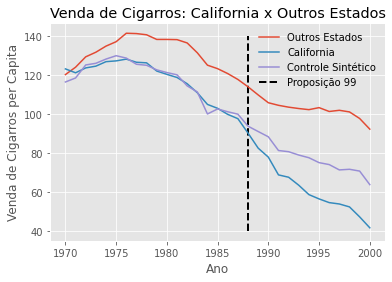

In [25]:
## Plottando
# Estilo dos gráficos
from matplotlib import style
style.use("ggplot")

# Objeto gráfico
fig = plt.Figure(figsize=(10, 10), dpi=150)

# Plot
dfAgrupCaliCS.plot()

# Linha vertical da proposição 99
plt.vlines(x=1988, ymin=40, ymax=140, linestyle="--", lw=2, label="Proposição 99")

# Títulos
plt.xlabel("Ano")
plt.ylabel("Venda de Cigarros per Capita")
plt.title("Venda de Cigarros: California x Outros Estados")

## Configurando legenda com fundo transparente
plt.legend(frameon=False, facecolor=None)

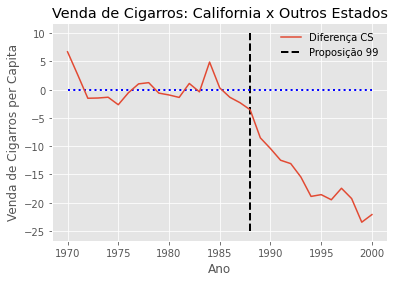

In [26]:
## Pegando as diferenças de cada ano e plottando
dfAgrupCaliCS["Diferença CS"] = dfAgrupCaliCS["California"] - dfAgrupCaliCS["Controle Sintético"]

# Objeto gráfico
fig = plt.Figure(figsize=(10, 10), dpi=150)

# Plot
dfAgrupCaliCS["Diferença CS"].plot()

# Linha vertical da proposição 99
plt.vlines(x=1988, ymin=-25, ymax=10, linestyle="--", lw=2, label="Proposição 99")

# Linha horizontal do 0
plt.hlines(y=0, xmin=1970, xmax=2000, linestyle=":", lw=2, colors='b')

# Títulos
plt.xlabel("Ano")
plt.ylabel("Venda de Cigarros per Capita")
plt.title("Venda de Cigarros: California x Outros Estados")

## Configurando legenda com fundo transparente
plt.legend(frameon=False, facecolor=None)

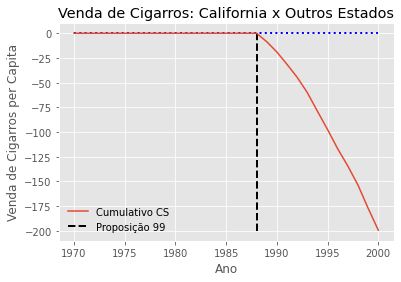

In [27]:
## Vendo efeitos cumulativos
## Somando as diferenças de cada ano PÓS tratamento
# Diferenças após tratamento
dfAgrupCaliCS["Diferença CS Pós"] = np.where(dfAgrupCaliCS.index <= 1988, 0, dfAgrupCaliCS["Diferença CS"])

dfAgrupCaliCS["Cumulativo CS"] = dfAgrupCaliCS["Diferença CS Pós"].cumsum()

# Objeto gráfico
fig = plt.Figure(figsize=(10, 10), dpi=150)

# Plot
dfAgrupCaliCS["Cumulativo CS"].plot()

# Linha vertical da proposição 99
plt.vlines(x=1988, ymin=-200, ymax=0, linestyle="--", lw=2, label="Proposição 99")

# Linha horizontal do 0
plt.hlines(y=0, xmin=1970, xmax=2000, linestyle=":", lw=2, colors='b')

# Títulos
plt.xlabel("Ano")
plt.ylabel("Venda de Cigarros per Capita")
plt.title("Venda de Cigarros: California x Outros Estados")

## Configurando legenda com fundo transparente
plt.legend(frameon=False, facecolor=None)

#### Testes de Validade - Placebos

E se o tratamento ocorresse em outro estado?

A ideia do teste de placebo é fazer com que todos os outros 38 estados sejam, cada uma de uma vez, unidades de tratamento, enquanto os demais (incluindo a California) formariam o controle sintético.

Assim, finge-se que o tratamento ocorreu em outro estado (e não California) e vê-se qual o resultado desse tratamento que não aconteceu. A ideia é comparar os resultados verdadeiros (California) com os "falsos" e ver se aqueles são maiores que estes.

In [28]:
## Pegando os valores para cada estado (demora um bom bucadinho -> +- 5min)
modControleSintetico.in_space_placebo(n_optim=5)

/usr/local/lib/python3.7/dist-packages/SyntheticControlMethods/plot.py:233: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(n_panels, 1, idx)


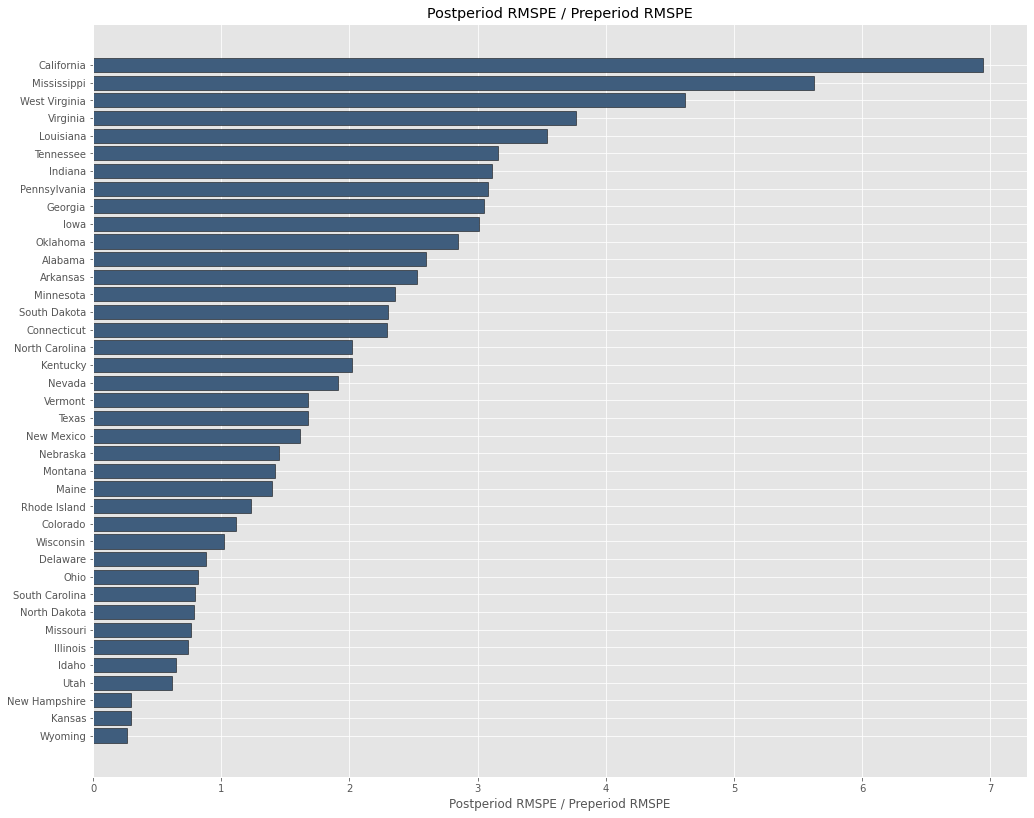

In [29]:
## Fazendo um plot dos root mean square prediction errors (raiz do erro quadrático médio de previsão)
## O gráfico mostra a razão entre os erros pós e pré tratamento: a lógica é que, na presença de um grande
## efeito de tratamento, a diferença entre a unidade de tratamento e sua contrapartida sintética seria bem
## maior quando comparada aos dados pré-tratamento. Assim, o ideal é que a nossa unidade verdadeira possua uma alta razão.

# Plottando
modControleSintetico.plot(['rmspe ratio'], 
                          treated_label="California", 
                          synth_label="California Sintética")

In [30]:
## Pegando os dados dos placebos de cada estado
mPlacebos = np.array(modControleSintetico.original_data.in_space_placebos)
mPlacebos.shape

(38, 31, 1)

In [31]:
## Temos 38 estados ao longo de 31 anos. Vamos arrumar a matriz (tirar a 3ª dimensão e transpô-la)
# Tirando a 3a dimensao
mPlacebos = np.squeeze(mPlacebos)

# Transpondo (teremos anos nas linhas e cada estado/placebo em uma coluna)
mPlacebos = mPlacebos.T
mPlacebos.shape

(31, 38)

In [32]:
## Criando um DataFrame
dfPlacebos = pd.DataFrame(mPlacebos, index=df['year'].unique())
dfPlacebos.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37
1970.0,5.347242,-0.500000,-9.669233,-13.599998,-34.875883,-10.099998,4.000000,-13.600006,-1.422845,-2.099998,-7.599998,16.599991,-7.500000,-17.935768,-15.749724,13.087403,-10.715242,-6.843685,-1.699997,-50.627894,-109.900009,16.400002,-16.599991,16.978296,-20.663792,-0.064018,-12.688994,-24.099998,-3.299995,8.791749,4.932695,2.842171e-14,24.500000,32.400002,-6.832488,2.059932,3.179937,-31.899994
1971.0,3.367476,2.200005,-7.582033,-12.199997,-38.370310,-9.399994,0.400002,-10.000000,4.307316,0.500000,2.599998,24.100006,-4.400002,-17.690992,-22.424582,3.622000,-12.492529,-4.318407,-3.199997,-44.958943,-114.500000,12.800003,-24.100006,14.040120,-18.299995,-2.699331,-1.128163,-16.899994,-10.900002,8.367463,2.066205,-3.500000e+00,24.900002,36.700005,-5.926117,7.232837,4.540217,-27.599998
1972.0,-1.030636,7.599998,-16.624597,-2.000000,-33.414726,-5.500000,-17.500000,-4.400002,12.505052,-0.800003,-2.199997,34.700012,-3.600006,-11.252678,2.767413,-3.252359,-12.109023,1.005355,3.900002,-39.464746,-116.800018,9.500000,-34.700012,13.983287,-13.278736,-6.868167,1.660831,-22.899994,-14.799995,8.713255,-3.333789,2.000046e-01,28.000000,18.300003,-9.745998,8.306550,-1.346843,-36.099998
1973.0,1.466922,1.699997,-21.698626,0.199997,-35.260846,-10.100006,-11.400002,-4.500000,14.069017,-0.199997,-5.699997,24.600006,-2.599998,-0.822722,-5.453156,-4.427014,-6.699308,8.703656,2.900002,-23.820208,-77.100006,10.599998,-24.600006,11.031008,-10.648509,-2.503988,3.071445,-32.300003,-17.500000,6.783336,0.901350,-9.000015e-01,26.200005,7.899994,-6.054433,9.687430,-2.408223,-33.199997
1974.0,-1.501309,5.100006,-13.849499,-0.599998,-30.191235,-8.899994,-10.900002,-9.999992,12.039527,-1.400002,-6.799995,14.900009,0.600006,1.770054,-4.076586,-2.268897,-6.668562,8.840344,1.300003,-17.944922,-57.399994,11.500000,-14.900009,12.240549,-7.390893,-5.929819,1.601240,-31.300003,-20.000000,3.608574,-2.519469,-2.899994e+00,24.700005,-0.500000,-8.132379,8.267909,-0.849151,-36.100006


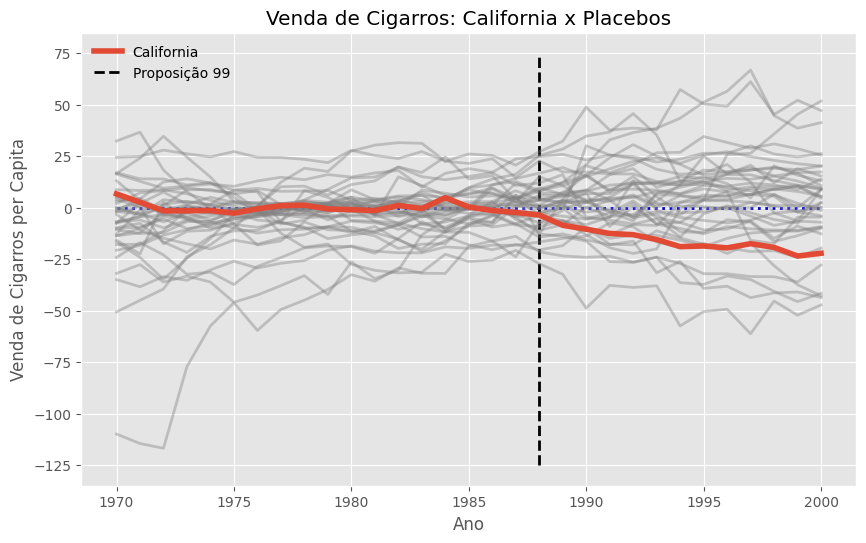

In [33]:
#### Plottando
### Objeto gráfico
plt.figure(figsize=(10, 6), dpi=100)

### Plottando cada placebo
## Número de estados - 1 (tirando California)
nEstados = df['state'].nunique() - 1

## Loopando através das colunas de dfPlacebos
for nEstado in range(nEstados):
  plt.plot(dfPlacebos.iloc[:, nEstado], color="gray", alpha=0.4, lw=2)

### Plottando California
plt.plot(dfAgrupCaliCS["Diferença CS"], label="California", lw=4)

# Linha vertical da proposição 99
plt.vlines(x=1988, ymin=-125, ymax=75, linestyle="--", lw=2, label="Proposição 99")

# Linha horizontal do 0
plt.hlines(y=0, xmin=1970, xmax=2000, linestyle=":", lw=2, colors='b')

# Títulos
plt.xlabel("Ano")
plt.ylabel("Venda de Cigarros per Capita")
plt.title("Venda de Cigarros: California x Placebos")

## Configurando legenda com fundo transparente
plt.legend(frameon=False, facecolor=None)

Como podemos ver, a variância após a intervenção é muito maior que a do período pré-intervenção, uma vez que o controle sintético minimiza as diferenças pré-intervenção.

Além disso, há algumas unidades que não podemos criar um bom controle até mesmo no período pré-intervenção, dadas suas características. Por exemplo, alguns estados podem ter consumo de cigarros muito altos, de forma que nenhuma combinação de outros estados chegue perto.

In [34]:
## Pegando os "bons" placebos
# Vetor de erros absolutos médios
dfPlacebos["Ano"] = dfPlacebos.index
vErrosAbsolutos = np.array(np.mean(dfPlacebos.query('Ano <= 1988'), axis=0))
vErrosAbsolutos = np.abs(vErrosAbsolutos[:-1])  # retirando Ano
vErrosAbsolutos

array([ 0.28382797,  2.45555496,  3.23444382,  2.49444453, 25.50170187,
        3.87222332,  4.79444419, 11.62777752,  0.79667443,  2.3722229 ,
        8.80555428,  8.19999695,  0.8777771 ,  0.57341087,  2.20630231,
        1.38560067,  0.06607207,  0.88288595,  0.26111179,  2.18660456,
       51.95555878, 14.73333316,  8.19999695,  1.59731002,  5.86032536,
        0.17067556,  0.83661716, 18.6611112 ,  9.48888821,  0.40904167,
        0.89012222,  7.07222154, 24.27222273,  1.33333418,  0.28141537,
        0.53757536,  1.97114094, 25.7166659 ])

In [35]:
## Vendo quantos estados tem erro absoluto menor do que 1
i = 0
for estado in vErrosAbsolutos:
  if estado < 1:
    i += 1

print(i)

13


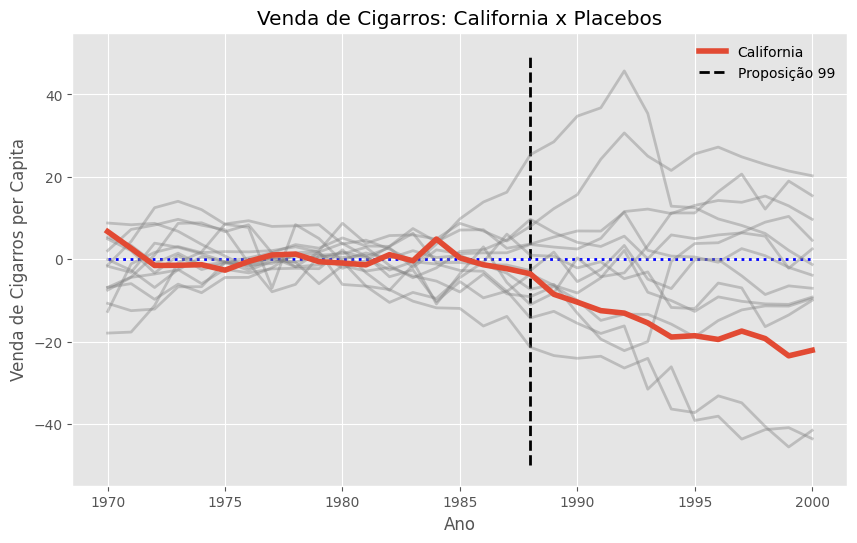

In [36]:
#### Plottando
### Objeto gráfico
plt.figure(figsize=(10, 6), dpi=100)

### Plottando cada placebo
for nEstado in range(nEstados):
  if vErrosAbsolutos[nEstado] < 1:
    plt.plot(dfPlacebos.iloc[:, nEstado], color="gray", alpha=0.4, lw=2)

### Plottando California
plt.plot(dfAgrupCaliCS["Diferença CS"], label="California", lw=4)

# Linha vertical da proposição 99
plt.vlines(x=1988, ymin=-50, ymax=50, linestyle="--", lw=2, label="Proposição 99")

# Linha horizontal do 0
plt.hlines(y=0, xmin=1970, xmax=2000, linestyle=":", lw=2, colors='b')

# Títulos
plt.xlabel("Ano")
plt.ylabel("Venda de Cigarros per Capita")
plt.title("Venda de Cigarros: California x Placebos")

## Configurando legenda com fundo transparente
plt.legend(frameon=False, facecolor=None)

Dos dois estados que possuem quedas maiores que a California (quando comparado ao seu respectivo controle sintético), um começa a apresentar queda desde o início de 1980, enquanto outro merece mais investigação.

## O Efeito do Terrorismo na Economia do País Basco

Será que os maiores números de terrorismo praticados pelo ETA a partir de 1969 tiveram efeitos negativos sobre a economia basca?

ETA: Euskadi Ta Askatasuna (em basco: Pátria Basca e Liberdade)

### Leitura dos Dados

In [37]:
## Arquivo
sArquivoBasco = "basque_data.csv"

## Lendo o DataFrame
dfBasco = pd.read_csv(f"{sCaminho}{sArquivoBasco}")

# Vendo o tamanho da base
print(f"Linhas: {dfBasco.shape[0]}; Colunas: {dfBasco.shape[1]}")

Linhas: 774; Colunas: 18


In [38]:
## Vendo as primeiras linha do df
dfBasco.head(10)

# sec: % do setor na economia como um todo (venta: comércio)
# school: % de pessoas naquela faixa educacional
# invest: taxa de investimento
# popdens: pessoas por quilômetro quadrado
# gdpcap: pib per capita

,Unnamed: 0,regionno,regionname,year,gdpcap,sec.agriculture,sec.energy,sec.industry,sec.construction,sec.services.venta,sec.services.nonventa,school.illit,school.prim,school.med,school.high,school.post.high,popdens,invest
0,1,1,Spain (Espana),1955,2.354542,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,Spain (Espana),1956,2.480149,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,Spain (Espana),1957,2.603613,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,Spain (Espana),1958,2.637104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1,Spain (Espana),1959,2.669880,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,1,Spain (Espana),1960,2.869966,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,1,Spain (Espana),1961,3.047486,19.540001,4.71,26.420000,6.27,36.619999,6.44,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,1,Spain (Espana),1962,3.273279,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,1,Spain (Espana),1963,3.493502,19.049999,4.31,26.049999,6.83,38.000000,5.77,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,1,Spain (Espana),1964,3.600114,NaN,NaN,NaN,NaN,NaN,NaN,2863.27832,18679.095703,1064.245728,359.745728,212.143417,NaN,18.360184


In [39]:
## Droppando colunas desnecessárias
dfBasco = dfBasco.drop(columns=["regionno", "Unnamed: 0"], axis=1) 

In [40]:
## Descrevendo o DataFrame
dfBasco.describe()

,year,gdpcap,sec.agriculture,sec.energy,sec.industry,sec.construction,sec.services.venta,sec.services.nonventa,school.illit,school.prim,school.med,school.high,school.post.high,popdens,invest
count,774.000000,774.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,108.000000,108.000000,108.000000,108.000000,108.000000,18.000000,576.000000
mean,1976.000000,5.394987,20.268445,5.188556,23.915333,7.211556,36.485222,6.934556,308.051261,2118.524959,145.613775,45.943488,25.458404,105.769444,21.395883
std,12.417698,2.242637,10.376150,4.035458,9.281848,1.361570,7.261439,1.978371,630.842242,4216.779749,297.452345,92.106997,51.579575,101.518005,4.111414
min,1955.000000,1.243430,1.320000,1.600000,9.560000,4.340000,26.230000,3.430000,8.097660,151.320892,8.609827,3.063398,1.660274,22.379999,9.331671
25%,1965.000000,3.693034,13.542500,2.697500,17.809999,6.240000,31.247500,5.497500,40.290497,432.293228,26.513481,9.131781,4.407411,44.772499,18.742375
50%,1976.000000,5.335690,19.240000,3.675000,23.135000,7.135000,34.750000,6.680000,116.232128,852.125793,47.752241,16.696211,7.712549,80.375000,21.350711
75%,1987.000000,6.869091,27.482500,6.080000,27.480000,8.177500,39.192500,7.927500,252.270393,1763.311646,119.039047,38.758285,19.058688,122.567497,23.750510
max,1997.000000,12.350043,46.500000,21.360001,46.220001,11.280000,58.209999,13.110000,2863.278320,19459.558594,1696.146851,474.941162,252.250000,442.450012,39.409801


In [41]:
## Vendo quantidade de Estados e anos
print(f"Estados: {dfBasco['regionname'].nunique()}.")
print(f"Anos: {dfBasco['year'].nunique()}.")

Estados: 18.
Anos: 43.


In [42]:
## Vendo os estados
dfBasco['regionname'].value_counts()

Murcia (Region de)              43
Andalucia                       43
Basque Country (Pais Vasco)     43
Extremadura                     43
Castilla Y Leon                 43
Cataluna                        43
Cantabria                       43
Canarias                        43
Aragon                          43
Madrid (Comunidad De)           43
Navarra (Comunidad Foral De)    43
Principado De Asturias          43
Galicia                         43
Rioja (La)                      43
Comunidad Valenciana            43
Spain (Espana)                  43
Baleares (Islas)                43
Castilla-La Mancha              43
Name: regionname, dtype: int64

### Análise Descritiva

In [43]:
## Antes de tudo, devemos retirar os dados da Espanha como um todo, já que ela contém o país basco
dfBasco = dfBasco.query("regionname != 'Spain (Espana)'")
dfBasco.shape

(731, 16)

In [44]:
## Criando dummy de país basco
# Antes, já pegando o DataFrame
dfBascoCS = dfBasco.copy()

# Dummy
dfBasco["pais_basco"] = np.where(
    dfBasco['regionname'] == "Basque Country (Pais Vasco)",
    1,
    0
) 

In [45]:
# Vendo resultado
dfBasco.query('pais_basco == 1').head(5)

,regionname,year,gdpcap,sec.agriculture,sec.energy,sec.industry,sec.construction,sec.services.venta,sec.services.nonventa,school.illit,school.prim,school.med,school.high,school.post.high,popdens,invest,pais_basco
688,Basque Country (Pais Vasco),1955,3.853185,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
689,Basque Country (Pais Vasco),1956,3.945658,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
690,Basque Country (Pais Vasco),1957,4.033562,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
691,Basque Country (Pais Vasco),1958,4.023422,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
692,Basque Country (Pais Vasco),1959,4.013782,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [46]:
## Vendo como se comportam as tendências de PIB per capita

# Agrupando por ano e California e pegando as médias anuais
dfAgrupBasco = dfBasco.groupby(['year', 'pais_basco'])['gdpcap'].mean().unstack()
dfAgrupBasco.head(5)

pais_basco,0,1
year,,
1955,2.335962,3.853185
1956,2.466090,3.945658
1957,2.593960,4.033562
1958,2.625701,4.023422
1959,2.657794,4.013782


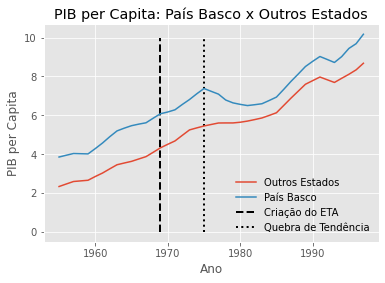

In [47]:
## Mudando as colunas
dfAgrupBasco.columns = ["Outros Estados", "País Basco"]
dfAgrupBasco.head(5)

# Objeto gráfico
fig = plt.Figure(figsize=(10, 10), dpi=150)

# Plot
dfAgrupBasco.plot()

# Linha vertical da criação do ETA
plt.vlines(x=1969, ymin=0, ymax=10, linestyle="--", lw=2, label="Criação do ETA")
plt.vlines(x=1975, ymin=0, ymax=10, linestyle=":", lw=2, label="Quebra de Tendência")

# Títulos
plt.xlabel("Ano")
plt.ylabel("PIB per Capita")
plt.title("PIB per Capita: País Basco x Outros Estados")

## Configurando legenda com fundo transparente
plt.legend(frameon=False, facecolor=None, loc="lower right")

### Estimação do Controle Sintético

In [48]:
# Ordenando
dfBascoCS.sort_values(by=["regionname", "year"], inplace=True, ignore_index=True)

In [49]:
## Fittando o modelo de controle sintético
modControleSinteticoBasco = Synth(dataset=dfBascoCS,
                             outcome_var="gdpcap",
                             id_var="regionname",
                             time_var="year",
                             treatment_period=1970,  # 1a observação APÓS a criação do ETA
                             treated_unit="Basque Country (Pais Vasco)",
                             n_optim=15,
                             pen="auto")  # corrige para vieses

In [50]:
## Vendo os pesos de cada região
modControleSinteticoBasco.original_data.weight_df

,Weight
Baleares (Islas),0.311075
Madrid (Comunidad De),0.483128
Rioja (La),0.205797


In [51]:
## Comparando os dados do país basco com o que foi gerado no controle sintético
# Queremos:
  # a) que as duas primeiras colunas sejam similares
  # b) que o WMAPE (weighted mean absolute pairwise error) seja pequeno relativamente aos valores das duas primeiras colunas
modControleSinteticoBasco.original_data.comparison_df

# Vemos que algumas variáveis, por conterem muitos NaNs, possuem um alto WMAPE

,Basque Country (Pais Vasco),Synthetic Basque Country (Pais Vasco),WMAPE,Importance
gdpcap,4.85,4.85,0.72,0.13
sec.agriculture,6.84,11.23,9.19,0.13
sec.energy,4.11,2.24,1.86,0.00
sec.industry,45.08,22.67,22.41,0.00
sec.construction,6.15,7.70,1.92,0.00
sec.services.venta,33.75,47.39,15.88,0.00
sec.services.nonventa,4.07,8.78,4.71,0.13
school.illit,39.89,81.12,53.88,0.13
school.prim,1031.74,1021.63,806.62,0.05
school.med,90.36,138.67,125.23,0.13


In [52]:
## Vendo o coeficiente de penalização usando para conserter vieses
# -> 0: não há viés; -> infinito: PSM
print(modControleSinteticoBasco.original_data.pen)

3.63991391603203


In [53]:
## Vendo os resultados para o controle sintético
vResultadosCSBasco = np.squeeze(modControleSinteticoBasco.original_data.synth_outcome)

In [54]:
## Adicionando a dfAgrupCali
dfAgrupBascoCS = dfAgrupBasco.copy()
dfAgrupBascoCS["Controle Sintético"] = vResultadosCSBasco

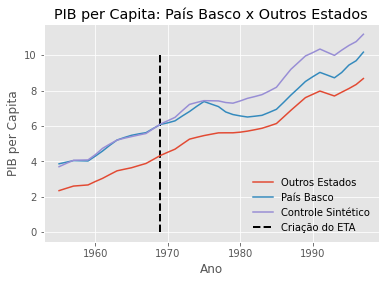

In [55]:
## Plottando

# Objeto gráfico
fig = plt.Figure(figsize=(10, 10), dpi=150)

# Plot
dfAgrupBascoCS.plot()

# Linha vertical da criação do ETA
plt.vlines(x=1969, ymin=0, ymax=10, linestyle="--", lw=2, label="Criação do ETA")

# Títulos
plt.xlabel("Ano")
plt.ylabel("PIB per Capita")
plt.title("PIB per Capita: País Basco x Outros Estados")

## Configurando legenda com fundo transparente
plt.legend(frameon=False, facecolor=None, loc="lower right")

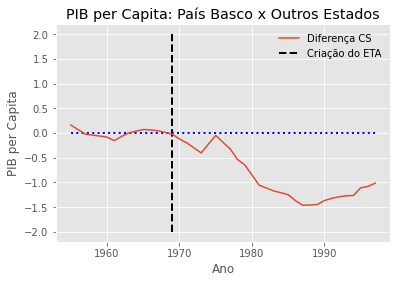

In [56]:
## Pegando as diferenças de cada ano e plottando
dfAgrupBascoCS["Diferença CS"] = dfAgrupBascoCS["País Basco"] - dfAgrupBascoCS["Controle Sintético"]

# Objeto gráfico
fig = plt.Figure(figsize=(10, 10), dpi=150)

# Plot
dfAgrupBascoCS["Diferença CS"].plot()

# Linha vertical da criação do ETA
plt.vlines(x=1969, ymin=-2, ymax=2, linestyle="--", lw=2, label="Criação do ETA")

# Linha horizontal de 0
plt.hlines(y=0, xmin=1955, xmax=1997, linestyle=":", lw=2, colors='b')

# Títulos
plt.xlabel("Ano")
plt.ylabel("PIB per Capita")
plt.title("PIB per Capita: País Basco x Outros Estados")

## Configurando legenda com fundo transparente
plt.legend(frameon=False, facecolor=None)

### Placebos

In [57]:
## Pegando os valores para cada estado (demora um bom bucadinho)
modControleSinteticoBasco.in_space_placebo(n_optim=3)

/usr/local/lib/python3.7/dist-packages/SyntheticControlMethods/plot.py:233: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(n_panels, 1, idx)


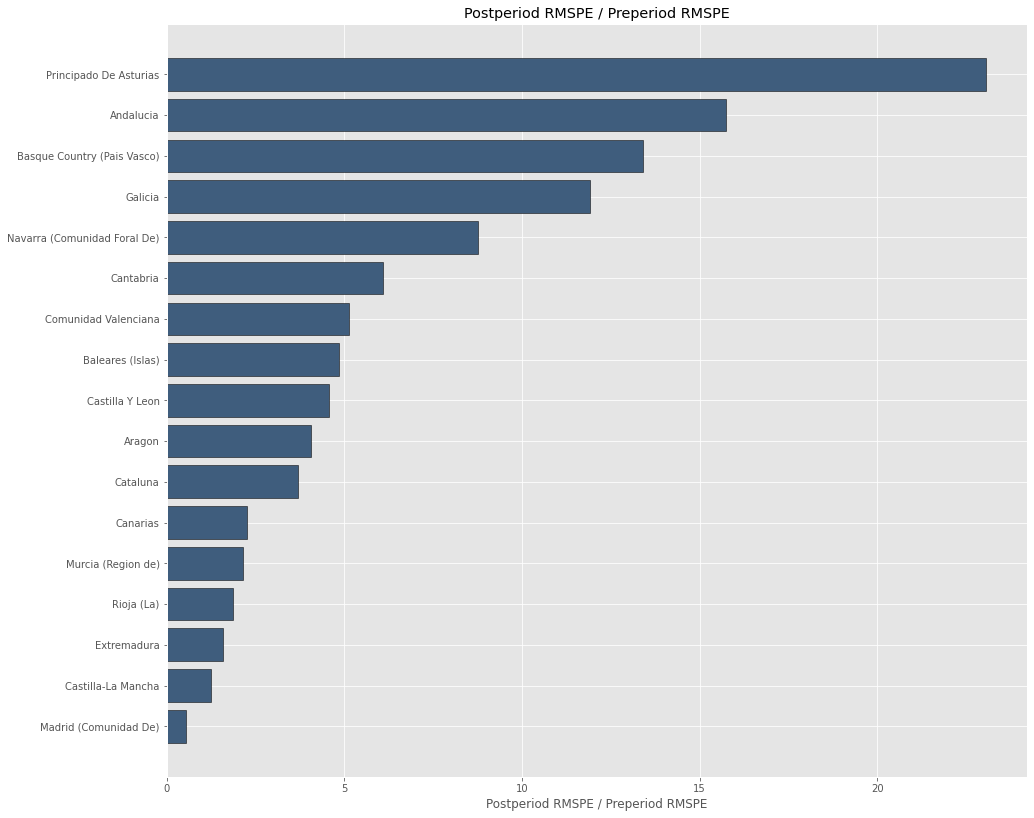

In [58]:
## Fazendo um plot dos root mean square prediction errors (raiz do erro quadrático médio de previsão)
## O gráfico mostra a razão entre os erros pós e pré tratamento: a lógica é que, na presença de um grande
## efeito de tratamento, a diferença entre a unidade de tratamento e sua contrapartida sintética seria bem
## maior quando comparada aos dados pré-tratamento. Assim, o ideal é que a nossa unidade verdadeira possua uma alta razão.

# Plottando
modControleSinteticoBasco.plot(['rmspe ratio'], 
                          treated_label="País Basco", 
                          synth_label="País Basco Sintético")

In [59]:
## Pegando os dados dos placebos de cada região
mPlacebosBasco= np.array(modControleSinteticoBasco.original_data.in_space_placebos)
mPlacebosBasco.shape

(16, 43, 1)

In [60]:
# Tirando a 3a dimensao
mPlacebosBasco = np.squeeze(mPlacebosBasco)

# Transpondo (teremos anos nas linhas e cada estado/placebo em uma coluna)
mPlacebosBasco = mPlacebosBasco.T
mPlacebosBasco.shape

(43, 16)

In [61]:
## Criando um DataFrame
dfPlacebosBasco = pd.DataFrame(mPlacebosBasco, index=dfBasco['year'].unique())
dfPlacebosBasco.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
1955,-0.097409,0.064692,0.526174,0.031300,-0.139684,-0.040417,0.360968,0.215110,-0.110979,0.436090,0.054056,-2.039346,0.172000,0.170288,-0.101451,0.753499
1956,-0.063966,0.039585,0.480478,-0.023826,-0.137052,-0.079834,0.343402,0.237472,-0.125955,0.431734,0.032919,-2.088475,0.171998,0.150924,-0.077346,0.812554
1957,-0.029220,0.011995,0.426634,-0.076138,-0.127710,-0.120037,0.324050,0.256362,-0.140058,0.427878,0.011140,-2.123608,0.169924,0.127880,-0.051991,0.869609
1958,-0.018952,0.017967,0.306232,-0.030272,-0.127159,-0.118609,0.321337,0.173798,-0.163798,0.447158,0.011854,-2.024279,0.165596,0.096918,-0.038840,0.916238
1959,-0.008967,0.026029,0.184867,0.018422,-0.132966,-0.117109,0.318695,0.092268,-0.181205,0.466010,0.012639,-1.915524,0.161655,0.058274,-0.019065,0.962011


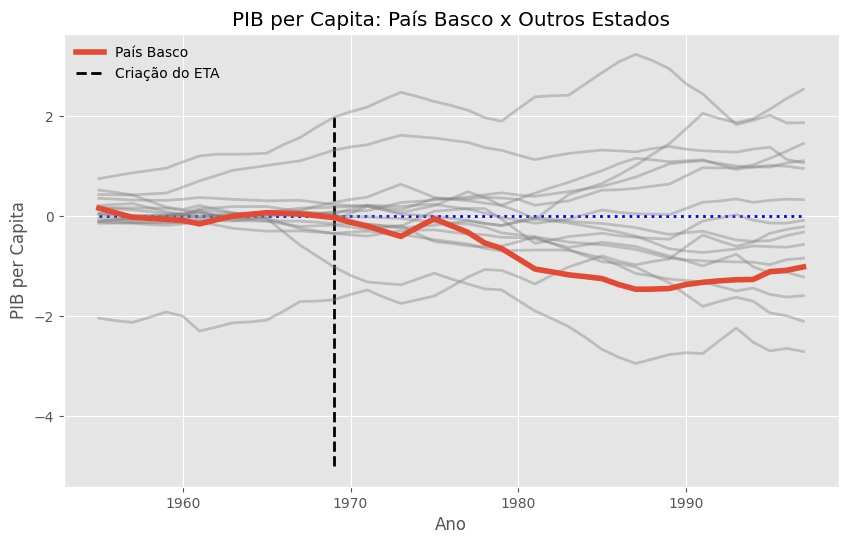

In [62]:
#### Plottando
### Objeto gráfico
plt.figure(figsize=(10, 6), dpi=100)

### Plottando cada placebo
## Número de regiões - 1 (tirando país basco)
nEstados = dfBasco['regionname'].nunique() - 1

## Loopando através das colunas de dfPlacebos
for nEstado in range(nEstados):
  plt.plot(dfPlacebosBasco.iloc[:, nEstado], color="gray", alpha=0.4, lw=2)

### Plottando California
plt.plot(dfAgrupBascoCS["Diferença CS"], label="País Basco", lw=4)

# Linha vertical da criação do ETA
plt.vlines(x=1969, ymin=-5, ymax=2, linestyle="--", lw=2, label="Criação do ETA")

# Linha horizontal de 0
plt.hlines(y=0, xmin=1955, xmax=1997, linestyle=":", lw=2, colors='b')

# Títulos
plt.xlabel("Ano")
plt.ylabel("PIB per Capita")
plt.title("PIB per Capita: País Basco x Outros Estados")

## Configurando legenda com fundo transparente
plt.legend(frameon=False, facecolor=None)

# Obrigado!!